In [12]:
import json
import pandas as pd

import MeCab

import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

from os import path
from PIL import Image
import numpy as np


In [13]:
stories_json = []
with open('./output_stories.json', 'r') as f:
    stories_json = stories_json + json.loads(f.read())

print(len(stories_json))
print(stories_json[1].keys())

395
dict_keys(['index', 'title', 'abstracts_list'])


In [14]:
stories_df = pd.DataFrame(stories_json)
stories_df["abstract_joined"] = stories_df["abstracts_list"].str.join(" ")
stories_df.head()

,index,title,abstracts_list,abstract_joined
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,[],
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],[],
2,0327,「やりクリしてハワイ旅行」「しずかちゃんのはごろも」[2013年4月26日放送],[],
3,0328,「ひるねは天国で」「どくさいスイッチ」[2013年5月3日放送],[],
4,0329,「インスタントママ」「狙われたジャイアン」[2013年5月10日放送],[],


In [15]:
t = MeCab.Tagger('-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')
def mecab_tokenizer(text):
    parsed_lines = t.parse(text).split("\n")[:-2]
    surfaces = [l.split('\t')[0] for l in parsed_lines]
    features = [l.split('\t')[1] for l in parsed_lines]
    # 原型を取得
    bases = [f.split(',')[6] for f in features]
    # 品詞を取得
    pos = [f.split(',')[0] for f in features]

    # 各単語を原型に変換する
    token_list = [b if b != '*' else s for s, b in zip(surfaces, bases)]
    # 瀕死を絞り込み
    target_pos = ["名詞", "その他"]
    token_list = [t for t, p in zip(token_list, pos) if p in target_pos]
    # アルファベットを小文字に統一
    token_list = [t.lower() for t in token_list]

    return [ text for text in filter(lambda x: not x.isascii(), token_list)]

In [16]:
# ストーリーが取得できたものに絞る
stories_df = stories_df[stories_df['abstract_joined'].str.len() > 0] 
sentences = stories_df["abstract_joined"].apply(mecab_tokenizer)
print(sentences)

143    [冬休み, ある日, あまり, 寒さ, 家, のび太, しずか, ジャイアン, 前, スネ夫...
144    [のび太, 部屋, 外, 自分, しずか, 声, バドミントン, 羽根, のび太, 家, 屋...
145    [吠, 近所, 犬, のび太, 今日, 声, ところ, 足, …。, みじめ, 姿, ドラえ...
146    [のび太, 学校, ドラえもん, ひみつ道具, 部屋, 中, 整理, のび太, 中, 絵本,...
147    [ジャイアン, 自分勝手, 言動, 乱暴, らんぼう, 態度, 嫌気, のび太, たち, ス...
                             ...                        
390    [商店街, カプセルトイ, 販売, はん, ばい, 機, ミニチュア, 商品, のび太, 大...
391    [中, ところ, パパ, ママ, ドラえもん, 旅行, 道具, お願い, のび太, ドラえも...
392    [夏休み, ジャイアン, 親せき, おじさん, 住職, じゅう, しょく, 寺, 遊び, こ...
393    [毎日, 勉強, テレビ, マンガ, 昼寝, のび太, パパ, 自分, しょうらい, ん, ...
394    [雲, ガス, 雲の上, 昼寝, のび太, しずか, 幸せ, 生活, 夢, 幸せ, 気持ち,...
Name: abstract_joined, Length: 252, dtype: object


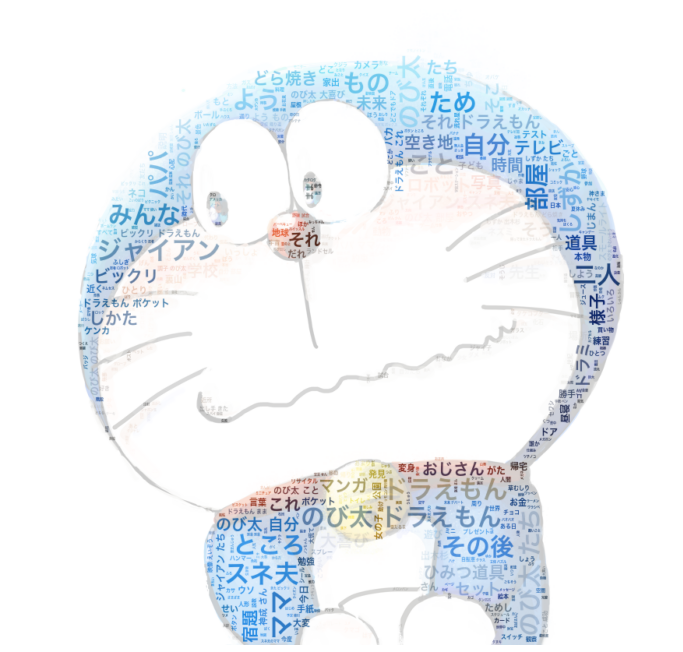

In [25]:
text = sentences.agg(' '.join).values
dora_coloring = np.array(Image.open(path.join("sample-dora.png")))

FONT_PATH = "/System/Library/Fonts/ヒラギノ角ゴシック W6.ttc"
wordcloud = WordCloud(
    width=1200, 
    height=1200, 
    background_color='white', 
    mask=dora_coloring,
    prefer_horizontal=0.75,
    relative_scaling=0,
    min_word_length=2,
    min_font_size=4,
    max_font_size=32,
    max_words=10000,
    repeat=False,
    font_path=FONT_PATH
).generate(str(' '.join(text)))

image_colors = ImageColorGenerator(dora_coloring)
dora_img = Image.open(path.join("sample-dora.png"))
dora_coloring = np.array(dora_img)

plt.figure(figsize=(12,12))

plt.imshow(dora_img, alpha=.8)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear", alpha=0.75)
plt.axis('off') #軸の表示を消す
plt.show()